Semi-Supervised Learning for Credit-Card Approval Project

Introduction: 
Dataset, that has been retrieved from remote server has over 90% of unlabeled data and 
at most 10% respectively. We need to predict labels of bad client for over 460000 samples, based on 
user personal information, provided. This Notebook prepares the dataset for the potential re-tranining by 
using semi-supervised learning technique

In [37]:
# let's start by loading the dataset 
import pandas, numpy
applications = pandas.read_csv("application_record.csv")
credit_records = pandas.read_csv("credit_record.csv")

In [38]:
# labeling data, presented in the credit records 

# Relabling Credit Records Dataset

CREDIT_MAPPING = {
    "ID": "client_id",
    "STATUS": "due_status",
    "MONTHS_BALANCE": "balance_month"
}
credit_records.rename(columns=CREDIT_MAPPING, inplace=True)

# Relabling Applications Records Dataset
APPLICATION_MAPPING = {
    "ID": "client_id",
    "CODE_GENDER": "gender",
    "FLAG_OWN_CAR": "has_car",
    "FLAG_OWN_REALTY": "has_realty",
    "CNT_CHILDREN": "total_children",
    "AMT_INCOME_TOTAL": "annual_income",
    "NAME_INCOME_TYPE": "income_category",
    "NAME_EDUCATION_TYPE": "education_category",
    "NAME_FAMILY_STATUS": "family_status",
    "NAME_HOUSING_TYPE": "living_place",
    "DAYS_BIRTH": "birthday",
    "FLAG_MOBIL": "has_mobile_phone",
    "FLAG_PHONE": "has_phone",
    "FLAG_WORK_PHONE": "has_work_phone",
    "FLAG_EMAIL": "has_email",
    "CNT_FAM_MEMBERS": "family_size",
    "OCCUPATION_TYPE": "job",
    'DAYS_EMPLOYED': 'days_employed',
}

applications.rename(columns=APPLICATION_MAPPING, inplace=True)


Null Values handling (Application Records)

In [39]:
applications.isnull().sum()

client_id                  0
gender                     0
has_car                    0
has_realty                 0
total_children             0
annual_income              0
income_category            0
education_category         0
family_status              0
living_place               0
birthday                   0
days_employed              0
has_mobile_phone           0
has_work_phone             0
has_phone                  0
has_email                  0
job                   134203
family_size                0
dtype: int64

In [40]:
missing_job = 'missing'
applications['job'].fillna(value=missing_job, inplace=True)

Null Values Handling (Credit Records)

In [41]:
credit_records.isna().sum()

client_id        0
balance_month    0
due_status       0
dtype: int64

Application Record Features

In [42]:
import math 

applications = applications.drop_duplicates(subset=["client_id"], keep='last', inplace=False)

applications['age'] = applications['birthday'].apply(lambda day: math.floor(abs(day) / 365))
applications['employed'] = applications['days_employed'].apply(lambda days: True if days < 0 else False)

dup_clients = applications['client_id'].value_counts().to_frame("number_of_apps").reset_index()
applications['exp_applicant'] = numpy.where(dup_clients['number_of_apps'] > 1, True, False)

applications.drop(columns=['birthday', 'days_employed'], inplace=True)

def create_married_feature(applications: pandas.DataFrame):

    non_mar_statuses = set(['Single / not married', 'Separated', 'Widow'])
    applications['family_status'] = applications['family_status'].apply(
        func=lambda status: True if status not in non_mar_statuses else False
    )
    return applications.rename(columns={'family_status': 'married'}, inplace=False)


def create_gender_feature(applications: pandas.DataFrame):

    encoded_data = pandas.get_dummies(
        applications['gender']
    ).rename(columns={'F': 'Female', 'M': 'Male'})

    applications = pandas.concat([applications, encoded_data], axis=1)
    applications.drop(columns=['gender'], inplace=True)
    return applications

applications = create_married_feature(applications)
applications = create_gender_feature(applications)

In [43]:
# Cleansing credit records dataset 
DUE_DATATYPES = {
    "0": 0,
    "1": 0,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 1,
    "X": 0,
    "C": 0
}
credit_records['due_status'] = credit_records['due_status'].map(lambda item: DUE_DATATYPES[item])

Credit Record Features

In [44]:
# introducing credit records features (bad client status)
credit_features = pandas.DataFrame()
credit_features['client_id'] = credit_records['client_id'].unique()
credit_features['overdues'] = pandas.Series(credit_records.groupby('client_id')['due_status'].sum().to_numpy())
credit_features['credit_window'] = numpy.abs(credit_records['balance_month'].min())
credit_features['overdue_perc'] = numpy.round(credit_features['overdues'] / credit_features['credit_window'], 2)

# annotating bad client status
credit_features['bad_client'] = numpy.where(credit_features['overdues'] > 0, True, False)
credit_features = credit_features[['client_id', 'bad_client']]

credit_features['bad_client'].value_counts()

bad_client
False    45318
True       667
Name: count, dtype: int64

Merging tables together

In [45]:
merged_dataset = applications.merge(credit_features, on='client_id', how='left')
merged_dataset

,client_id,has_car,has_realty,total_children,annual_income,income_category,education_category,married,living_place,has_mobile_phone,...,has_phone,has_email,job,family_size,age,employed,exp_applicant,Female,Male,bad_client
0,5008804,Y,Y,0,427500.0,Working,Higher education,True,Rented apartment,1,...,0,0,missing,2.0,32,True,False,False,True,False
1,5008805,Y,Y,0,427500.0,Working,Higher education,True,Rented apartment,1,...,0,0,missing,2.0,32,True,False,False,True,False
2,5008806,Y,Y,0,112500.0,Working,Secondary / secondary special,True,House / apartment,1,...,0,0,Security staff,2.0,58,True,False,False,True,False
3,5008808,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,False,House / apartment,1,...,1,1,Sales staff,1.0,52,True,False,True,False,False
4,5008809,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,False,House / apartment,1,...,1,1,Sales staff,1.0,52,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,N,Y,0,135000.0,Pensioner,Secondary / secondary special,False,House / apartment,1,...,0,0,missing,1.0,62,False,False,False,True,NaN
438506,6840222,N,N,0,103500.0,Working,Secondary / secondary special,False,House / apartment,1,...,0,0,Laborers,1.0,43,True,False,True,False,NaN
438507,6841878,N,N,0,54000.0,Commercial associate,Higher education,False,With parents,1,...,0,0,Sales staff,1.0,22,True,False,True,False,NaN
438508,6842765,N,Y,0,72000.0,Pensioner,Secondary / secondary special,True,House / apartment,1,...,0,0,missing,2.0,59,False,False,True,False,NaN


Preparing dataset

In [46]:
def encode_bool_features(dataset: pandas.DataFrame):
    """
    Function standardizes boolean features to the following format 
        True: (Y, 1)
        False: (N, 0)
    Args:
        dataset: pandas.DataFrame object, containing boolean features
    """
    bool_features = ['has_car', 'has_realty', 'has_phone', 'has_email', 'has_mobile_phone', 'has_work_phone']
    if not all(feature in dataset.columns for feature in bool_features): return 

    for feature in bool_features:
        dataset[feature] = dataset[feature].map(
            {
                'Y': True,
                'N': False,
                1: True,
                0: False
            }
        )

def encode_bad_client_status(dataset: pandas.DataFrame):
    """
    Function encodes bad client status by applying new category called 'missing'
    """

encode_bool_features(merged_dataset)

Dataset Splitting (training, testing)

In [47]:
from sklearn.model_selection import train_test_split 

def split_data(data, proportions):
    # Calculate the cumulative sum of proportions
    cumulative_proportions = numpy.cumsum(proportions)
    
    # Normalize the proportions
    normalized_proportions = cumulative_proportions / cumulative_proportions[-1]
    
    # Generate random indices for shuffling the data
    indices = numpy.random.permutation(data.shape[0])
    
    # Split the data based on the proportions

    splits = []
    start_index = 0
    
    for proportion in normalized_proportions:
        end_index = int(proportion * data.shape[0])
        splits.append(data.iloc[indices[start_index:end_index]])
        start_index = end_index
    
    return splits

proportions = [0.5, 0.5]
splits = split_data(merged_dataset, proportions)

training_set = splits[0]
testing_set = splits[1]

print(len(training_set), len(testing_set))

training_set

219255 219255


,client_id,has_car,has_realty,total_children,annual_income,income_category,education_category,married,living_place,has_mobile_phone,...,has_phone,has_email,job,family_size,age,employed,exp_applicant,Female,Male,bad_client
309025,6231419,False,True,1,180000.0,Working,Higher education,True,House / apartment,True,...,False,True,Sales staff,3.0,43,True,False,True,False,NaN
21601,5062680,False,True,0,112500.0,Working,Higher education,False,House / apartment,True,...,False,False,Accountants,1.0,61,True,False,True,False,False
201593,5906282,True,False,0,315000.0,Working,Higher education,True,House / apartment,True,...,True,False,Managers,2.0,35,True,False,True,False,NaN
17733,5051253,True,False,0,121500.0,Pensioner,Secondary / secondary special,False,House / apartment,True,...,False,False,missing,1.0,63,False,False,True,False,False
72735,5270915,True,False,0,135000.0,Working,Higher education,True,House / apartment,True,...,False,False,High skill tech staff,2.0,52,True,False,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35009,5609697,False,True,2,184500.0,Working,Secondary / secondary special,True,House / apartment,True,...,True,True,missing,4.0,31,True,False,False,True,NaN
39064,5113235,False,True,1,175500.0,Working,Secondary / secondary special,True,House / apartment,True,...,False,False,Cleaning staff,3.0,45,True,False,True,False,False
305997,6223139,False,True,0,135000.0,Pensioner,Secondary / secondary special,True,House / apartment,True,...,False,False,missing,2.0,60,False,False,True,False,NaN
331397,6348043,True,True,2,85500.0,Commercial associate,Higher education,True,House / apartment,True,...,False,False,Managers,4.0,32,True,False,True,False,NaN


Feature Encoding

In [48]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

def encode_job_feature(dataset: pandas.DataFrame):
    """
    Function encodes job feature using Label Encoder

    Args:
        dataset: pandas.DataFrame object, containing job feature
    """
    if not 'job' in dataset.columns: return 
    frequencies = dataset['job'].value_counts().to_dict()
    dataset['job'] = dataset['job'].map(frequencies)

def encode_education_feature(dataset: pandas.DataFrame):
    """
    Function encodes education category feature using Ordinal Encoding 

    What steps function performs:

        1. Cleans and upgrades category labels 
        2. Selects the right education order (hierarchy) in descending order (Academic Degree, Higher Education, ...)
        3. Encodes Categories 

    Args:
        dataset: pandas.DataFrame object, containing education feature
    """
    if not 'education_category' in dataset.columns: return 

    dataset['education_category'] = dataset['education_category'].map({
    'Secondary / secondary special': 'special secondary',
    'Incomplete higher': 'incomplete higher education',
    'Academic degree': 'academic degree',
    'Higher education': 'higher education',
    'Lower secondary': 'lower secondary'
    })

    education_categories = [
        "academic degree",
        "higher education",
        "incomplete higher education",
        "special secondary",
        "lower secondary",
    ]

    encoder = OrdinalEncoder(categories=[education_categories], dtype=numpy.int8)
    dataset['education_category'] = encoder.fit_transform(dataset[['education_category']])

def encode_living_place_feature(dataset: pandas.DataFrame):
    """
    Function encodes `living place` dataset using Ordinal Encoding 
    
    Args:
        dataset: pandas.DataFrame object, containing living_place feature
    """
    if not 'living_place' in dataset.columns: return 
    living_categories = [
        'Co-op apartment',
        'Office apartment',
        'Municipal apartment',
        'Rented apartment', 
        'House / apartment',
        'With parents',
    ]
    encoder = OrdinalEncoder(dtype=numpy.int8, categories=[living_categories])
    dataset['living_place'] = encoder.fit_transform(dataset[['living_place']])


def encode_income_category_feature(dataset: pandas.DataFrame):
    """
    Function encodes income category feature using Label Encoding

    Args:
        dataset: pandas.DataFrame object, containing income category feature
    """
    if not 'income_category' in dataset.columns: return 
    frequencies = dataset['income_category'].value_counts().to_dict()
    dataset['income_category'] = dataset['income_category'].map(frequencies)


def encode_dataset(merged_dataset: pandas.DataFrame):
    """
    Encodes all feature dataset using appropriate
    feature encoding techniques 
    """
    encode_job_feature(merged_dataset)
    encode_education_feature(merged_dataset)
    encode_living_place_feature(merged_dataset)
    encode_income_category_feature(merged_dataset)
    return merged_dataset

print(len(training_set), len(testing_set))

training_set = encode_dataset(training_set)
testing_set = encode_dataset(testing_set)

training_set


219255 219255


/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_1152/716717188.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['job'] = dataset['job'].map(frequencies)
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_1152/716717188.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['education_category'] = dataset['education_category'].map({
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_1152/716717188.py:47: SettingWithCopyWarning: 
A value is trying to be set on a co

,client_id,has_car,has_realty,total_children,annual_income,income_category,education_category,married,living_place,has_mobile_phone,...,has_phone,has_email,job,family_size,age,employed,exp_applicant,Female,Male,bad_client
309025,6231419,False,True,1,180000.0,112923,1,True,4,True,...,False,True,20519,3.0,43,True,False,True,False,NaN
21601,5062680,False,True,0,112500.0,112923,1,False,4,True,...,False,False,8048,1.0,61,True,False,True,False,False
201593,5906282,True,False,0,315000.0,112923,1,True,4,True,...,True,False,17679,2.0,35,True,False,True,False,NaN
17733,5051253,True,False,0,121500.0,37874,3,False,4,True,...,False,False,67084,1.0,63,False,False,True,False,False
72735,5270915,True,False,0,135000.0,112923,1,True,4,True,...,False,False,8666,2.0,52,True,False,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35009,5609697,False,True,2,184500.0,112923,3,True,4,True,...,True,True,67084,4.0,31,True,False,False,True,NaN
39064,5113235,False,True,1,175500.0,112923,3,True,4,True,...,False,False,2836,3.0,45,True,False,True,False,False
305997,6223139,False,True,0,135000.0,37874,3,True,4,True,...,False,False,67084,2.0,60,False,False,True,False,NaN
331397,6348043,True,True,2,85500.0,50456,1,True,4,True,...,False,False,17679,4.0,32,True,False,True,False,NaN


Standardization

In [49]:
# before training models, we need to make sure, that numeric data falls in the same scales 
# otherwise some machine learning algorithms might end up having poor prediction ability 

from sklearn.preprocessing import StandardScaler 

numeric_features = merged_dataset.select_dtypes(include='number').drop(columns=['client_id']).columns
other_features = merged_dataset.drop(columns=numeric_features, inplace=False).columns

def scale_numeric_features(feature_dataset: pandas.DataFrame):
    """
    Function scales numeric features using Standard Scaler 
    std = 1, mean = 0
    """
    scaler = StandardScaler()
    df = pandas.DataFrame(
    data=scaler.fit_transform(feature_dataset), 
    columns=feature_dataset.columns, index=feature_dataset.index)
    return df

training_numerics = scale_numeric_features(
    feature_dataset=training_set[numeric_features]
)

testing_numerics = scale_numeric_features(
    feature_dataset=testing_set[numeric_features]
)

training_set = pandas.concat([
    training_set[other_features],
    training_numerics
], axis=1)

testing_set = pandas.concat([
    testing_set[other_features],
    testing_numerics
], axis=1)


Merging training and testing sets into single one

In [50]:
merged_dataset = pandas.concat([
    training_set,
    testing_set
], axis=0)

merged_dataset.drop(columns=['client_id'])

merged_dataset

,client_id,has_car,has_realty,income_category,education_category,married,living_place,has_mobile_phone,has_work_phone,has_phone,...,job,employed,exp_applicant,Female,Male,bad_client,total_children,annual_income,family_size,age
309025,6231419,False,True,112923,1,True,4,True,False,False,...,20519,True,False,True,False,NaN,0.786576,-0.069839,0.895190,-0.028319
21601,5062680,False,True,112923,1,False,4,True,False,False,...,8048,True,False,True,False,False,-0.590664,-0.686533,-1.330288,1.540262
201593,5906282,True,False,112923,1,True,4,True,True,True,...,17679,True,False,True,False,NaN,-0.590664,1.163550,-0.217549,-0.725466
17733,5051253,True,False,37874,3,False,4,True,False,False,...,67084,False,False,True,False,False,-0.590664,-0.604307,-1.330288,1.714548
72735,5270915,True,False,112923,1,True,4,True,True,False,...,8666,True,False,False,True,NaN,-0.590664,-0.480968,-0.217549,0.755971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214733,5949190,True,True,50283,1,True,4,True,False,False,...,3930,True,False,False,True,NaN,-0.588535,-0.066824,-0.215934,-0.028580
394408,6685123,False,True,113164,3,True,4,True,False,False,...,67103,True,False,True,False,NaN,-0.588535,1.152656,-0.215934,0.407729
353032,6464301,False,False,113164,3,True,4,True,True,False,...,862,True,False,True,False,NaN,0.793293,-0.879810,0.900473,-0.115842
46585,6704599,False,False,37609,3,False,4,True,False,False,...,67103,False,False,True,False,NaN,-0.588535,-0.473317,-1.332341,1.803917


Semi Supervised Learning Analysis

In [51]:
# Separating data into labeled and unlabeled datasets 

labeled_data = merged_dataset[merged_dataset['bad_client'].notnull()]
unlabeled_data = merged_dataset[merged_dataset['bad_client'].isnull()]

In [52]:
# Splitting data into training, validation and test sets
from sklearn.model_selection import train_test_split 

Xl_data, Yl_data = labeled_data.drop(columns=['bad_client']), labeled_data['bad_client']
X_train, X_test, Y_train, Y_test = train_test_split(Xl_data, Yl_data, stratify=Yl_data, test_size=0.4)

# Splitting into training and validation sets 

training_set = (X_train, Y_train.astype(numpy.bool_))
test_set = (X_test, Y_test.astype(numpy.bool_))

In [53]:
# splitting unlabeled data
X_unlabeled_data = unlabeled_data.drop(columns=['bad_client'], inplace=False)

Semi Supervised Learning (Learning on Labeled Data)

In [54]:
from sklearn.semi_supervised import LabelPropagation
import sklearn.exceptions, logging
from sklearn.metrics import classification_report

Logger = logging.getLogger(__name__)

prop_params = {
    'kernel': 'knn',
    'n_neighbors': 4,
    'n_jobs': 2,
}

prop = LabelPropagation(**prop_params)
# training classifier propagation using training set 
prop.fit(training_set[0], training_set[1])

predicted_labels = pandas.DataFrame() 

def predict_unlabeled_data():
    try:
        probs = numpy.array(prop.predict_proba(X_test))
        predicted_labels['pos_prob'] = probs[:, 1]
        predicted_labels['neg_prob'] = probs[:, 0]
        predicted_labels['value'] = prop.predict(test_set[0])
    except(sklearn.exceptions.NotFittedError) as fit_err:
        Logger.debug("unlabeled data is invalid. %s" % fit_err)
        raise RuntimeError("Failed to label data")

predict_unlabeled_data()

classification_report(
    y_true=test_set[1], 
    y_pred=predicted_labels['value'],
    target_names=['bad_client', 'good_client']
)

"""             precision    recall  f1-score   support
  bad_client       0.89      0.95      0.92     14337
  good_client      0.95      0.88      0.91     14336
  
  accuracy                            0.92     28673
  macro avg       0.92      0.92      0.92     28673
  weighted avg    0.92      0.92      0.92     28673
"""


'             precision    recall  f1-score   support\n  bad_client       0.89      0.95      0.92     14337\n  good_client      0.95      0.88      0.91     14336\n  \n  accuracy                            0.92     28673\n  macro avg       0.92      0.92      0.92     28673\n  weighted avg    0.92      0.92      0.92     28673\n'

Predicting Labels

In [55]:
unlabeled_metrics = pandas.DataFrame()

unlabeled_metrics['prob'] = numpy.array(prop.predict_proba(X_unlabeled_data))[:, 1]
unlabeled_metrics['value'] = prop.predict(X_unlabeled_data)

unlabeled_metrics

unlabeled_metrics['value'].value_counts()

value
False    402053
Name: count, dtype: int64

Setting up missing labels

In [56]:
unlabeled_metrics.set_index(unlabeled_data.index, inplace=True)

unlabeled_data.loc[:, 'bad_client'] = unlabeled_metrics['value']

merged_dataset.loc[merged_dataset['bad_client'].isnull(), 'bad_client'] = unlabeled_data['bad_client']

In [57]:
merged_dataset

,client_id,has_car,has_realty,income_category,education_category,married,living_place,has_mobile_phone,has_work_phone,has_phone,...,job,employed,exp_applicant,Female,Male,bad_client,total_children,annual_income,family_size,age
309025,6231419,False,True,112923,1,True,4,True,False,False,...,20519,True,False,True,False,False,0.786576,-0.069839,0.895190,-0.028319
21601,5062680,False,True,112923,1,False,4,True,False,False,...,8048,True,False,True,False,False,-0.590664,-0.686533,-1.330288,1.540262
201593,5906282,True,False,112923,1,True,4,True,True,True,...,17679,True,False,True,False,False,-0.590664,1.163550,-0.217549,-0.725466
17733,5051253,True,False,37874,3,False,4,True,False,False,...,67084,False,False,True,False,False,-0.590664,-0.604307,-1.330288,1.714548
72735,5270915,True,False,112923,1,True,4,True,True,False,...,8666,True,False,False,True,False,-0.590664,-0.480968,-0.217549,0.755971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214733,5949190,True,True,50283,1,True,4,True,False,False,...,3930,True,False,False,True,False,-0.588535,-0.066824,-0.215934,-0.028580
394408,6685123,False,True,113164,3,True,4,True,False,False,...,67103,True,False,True,False,False,-0.588535,1.152656,-0.215934,0.407729
353032,6464301,False,False,113164,3,True,4,True,True,False,...,862,True,False,True,False,False,0.793293,-0.879810,0.900473,-0.115842
46585,6704599,False,False,37609,3,False,4,True,False,False,...,67103,False,False,True,False,False,-0.588535,-0.473317,-1.332341,1.803917


Data Splitting (training, testing, validation) sets 

In [61]:
from sklearn.model_selection import train_test_split 

x, y = merged_dataset.drop(columns=['bad_client'], inplace=False), merged_dataset['bad_client']

x_train, x_test, y_train, y_test = train_test_split(
        x, y, 
        shuffle=True, 
        random_state=1, 
        stratify=y, 
        test_size=0.5
)

x_train, x_validation, y_train, y_validation = train_test_split(
        x_train, y_train, 
        shuffle=True,
        test_size=0.5, 
        stratify=y_train, 
        random_state=1
)

training_set = pandas.concat([x_train, y_train], axis=1)
testing_set = pandas.concat([x_test, y_test], axis=1)
validation_set = pandas.concat([x_validation, y_validation], axis=1)

training_set

,client_id,has_car,has_realty,income_category,education_category,married,living_place,has_mobile_phone,has_work_phone,has_phone,...,job,employed,exp_applicant,Female,Male,total_children,annual_income,family_size,age,bad_client
267160,6079736,False,True,37874,3,True,4,True,False,False,...,67084,False,False,False,True,-0.590664,-0.275403,-0.217549,1.801692,False
150944,5709711,True,False,37874,3,False,4,True,False,False,...,67084,False,False,True,False,-0.590664,-0.809872,-1.330288,1.627405,False
119735,5541223,False,False,113164,3,True,5,True,True,True,...,20577,True,False,True,False,0.793293,-1.083057,0.900473,-1.075721,False
63708,5213479,False,True,50283,1,True,4,True,False,False,...,17804,True,False,False,True,2.175122,1.559149,2.016881,-0.639413,False
69744,5258177,True,False,37874,3,True,2,True,False,False,...,67084,False,False,False,True,0.786576,0.752420,0.895190,1.453118,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387087,6637083,False,True,112923,3,False,4,True,False,False,...,21507,True,False,False,True,-0.590664,-0.892098,-1.330288,-1.771186,False
438270,6731391,True,False,50283,3,True,4,True,False,False,...,20577,True,False,True,False,-0.588535,-0.270070,-0.215934,0.669514,False
225465,5979201,False,True,113164,1,True,4,True,False,False,...,17804,True,False,True,False,-0.588535,0.136423,-0.215934,0.931299,False
112288,5499753,True,True,113164,2,True,4,True,False,False,...,20577,True,False,False,True,0.793293,0.746163,0.900473,-0.901198,False


In [62]:
training_set

,client_id,has_car,has_realty,income_category,education_category,married,living_place,has_mobile_phone,has_work_phone,has_phone,...,job,employed,exp_applicant,Female,Male,total_children,annual_income,family_size,age,bad_client
267160,6079736,False,True,37874,3,True,4,True,False,False,...,67084,False,False,False,True,-0.590664,-0.275403,-0.217549,1.801692,False
150944,5709711,True,False,37874,3,False,4,True,False,False,...,67084,False,False,True,False,-0.590664,-0.809872,-1.330288,1.627405,False
119735,5541223,False,False,113164,3,True,5,True,True,True,...,20577,True,False,True,False,0.793293,-1.083057,0.900473,-1.075721,False
63708,5213479,False,True,50283,1,True,4,True,False,False,...,17804,True,False,False,True,2.175122,1.559149,2.016881,-0.639413,False
69744,5258177,True,False,37874,3,True,2,True,False,False,...,67084,False,False,False,True,0.786576,0.752420,0.895190,1.453118,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387087,6637083,False,True,112923,3,False,4,True,False,False,...,21507,True,False,False,True,-0.590664,-0.892098,-1.330288,-1.771186,False
438270,6731391,True,False,50283,3,True,4,True,False,False,...,20577,True,False,True,False,-0.588535,-0.270070,-0.215934,0.669514,False
225465,5979201,False,True,113164,1,True,4,True,False,False,...,17804,True,False,True,False,-0.588535,0.136423,-0.215934,0.931299,False
112288,5499753,True,True,113164,2,True,4,True,False,False,...,20577,True,False,False,True,0.793293,0.746163,0.900473,-0.901198,False


Setting Datatypes

In [63]:
def set_datatypes(df):
    # Numeric Data
    df['total_children'] = df['total_children'].astype(numpy.int8)
    df['annual_income'] = df['annual_income'].astype(numpy.int64)
    df['age'] = df['age'].astype(numpy.int8)

    # Boolean Data
    df['has_car'] = df['has_car'].astype(numpy.bool_)
    df['has_realty'] = df['has_realty'].astype(numpy.bool_)
    df['has_phone'] = df['has_phone'].astype(numpy.bool_)
    df['has_mobile_phone'] = df['has_mobile_phone'].astype(numpy.bool_)
    df['married'] = df['married'].astype(numpy.bool_)
    df['Male'] = df['Male'].astype(numpy.bool_)
    df['Female'] = df['Female'].astype(numpy.bool_)
    df['employed'] = df['employed'].astype(numpy.bool_)
    df['exp_applicant'] = df['exp_applicant'].astype(numpy.bool_)

    # Categorical Data
    df['income_category'] = df['income_category'].astype(numpy.int8)
    df['living_place'] = df['living_place'].astype(numpy.int8)
    df['education_category'] = df['education_category'].astype(numpy.int8)
    df['job'] = df['job'].astype(numpy.int8)

set_datatypes(training_set)
set_datatypes(testing_set)
set_datatypes(validation_set)

Class Imbalance Handling

In [64]:
# Splitting data

from imblearn.over_sampling import SMOTE 


def balance_dataset(encoded_dataset: pandas.DataFrame):
    X_data = encoded_dataset.drop(columns=['bad_client'], inplace=False)
    Y_data = encoded_dataset['bad_client'].astype(numpy.bool_)

    smote_classifier = SMOTE(k_neighbors=5, random_state=42)
    X_sampled, Y_sampled = smote_classifier.fit_resample(X_data, Y_data)
    balanced_set = pandas.concat([X_sampled, Y_sampled], axis=1).sort_values('client_id')
    return balanced_set 


training_set = balance_dataset(training_set)
testing_set = balance_dataset(testing_set)
validation_set = balance_dataset(validation_set)


Checking Class Imbalance using visualization libraries

In [66]:
import seaborn as sns

<Axes: xlabel='bad_client', ylabel='count'>

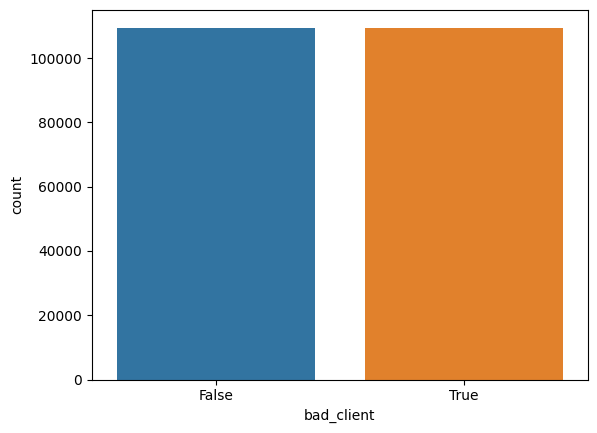

In [67]:
sns.countplot(data=training_set, x='bad_client')

<Axes: xlabel='bad_client', ylabel='count'>

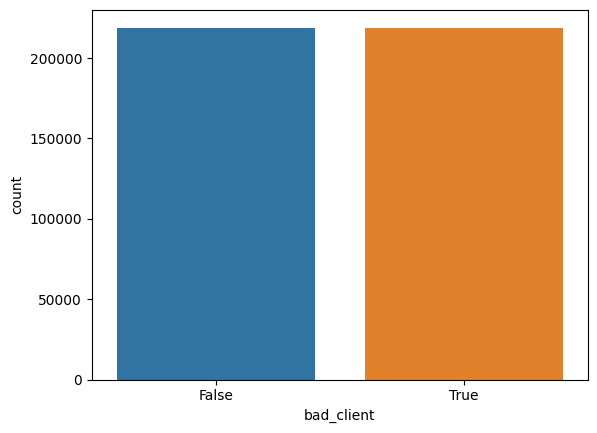

In [68]:
sns.countplot(data=testing_set, x='bad_client')

<Axes: xlabel='bad_client', ylabel='count'>

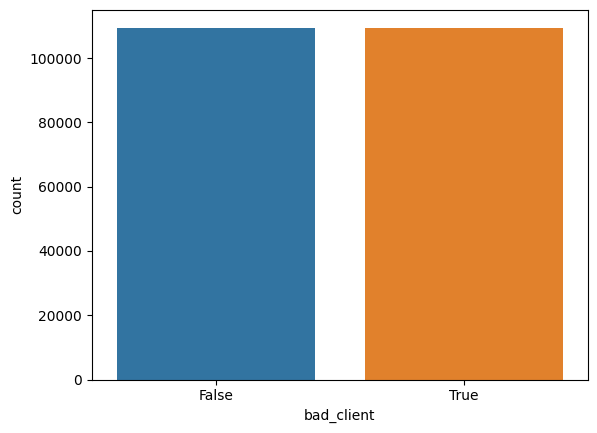

In [69]:
sns.countplot(data=validation_set, x='bad_client')

Saving new datasets to a CSV Files

In [72]:
training_set.to_csv("training_set.csv")
testing_set.to_csv('testing_set.csv')
validation_set.to_csv("validation_set.csv")
